<a href="https://colab.research.google.com/github/sjg230/QCES_LNM/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [122]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


In [123]:
import matplotlib

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

in more explict notation:

$$ \frac{\partial u}{\partial t} + g \frac{\partial h}{\partial x} = - u \frac{\partial u}{\partial x}$$
$$ \frac{\partial h}{\partial t} + \frac{\partial (Hu)}{\partial x} = -\frac{\partial (hu)}{\partial x}$$


In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [124]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


2024-12-27 15:39:43,992 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


INFO:__main__:Starting main loop


2024-12-27 15:39:43,999 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-27 15:39:44,192 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-27 15:39:44,198 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-27 15:39:44,201 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.06696 sec


2024-12-27 15:39:44,205 solvers 0/1 INFO :: Setup time (init - iter 0): 0.06696 sec


INFO:solvers:Warmup time (iter 0-10): 0.04266 sec


2024-12-27 15:39:44,207 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04266 sec


INFO:solvers:Run time (iter 10-end): 0.1531 sec


2024-12-27 15:39:44,210 solvers 0/1 INFO :: Run time (iter 10-end): 0.1531 sec


INFO:solvers:CPU time (iter 10-end): 4.254e-05 cpu-hr


2024-12-27 15:39:44,213 solvers 0/1 INFO :: CPU time (iter 10-end): 4.254e-05 cpu-hr


INFO:solvers:Speed: 1.201e+06 mode-stages/cpu-sec


2024-12-27 15:39:44,216 solvers 0/1 INFO :: Speed: 1.201e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 15:39:44,324 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnidfzevw/temp.m4v


2024-12-27 15:39:44,328 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnidfzevw/temp.m4v


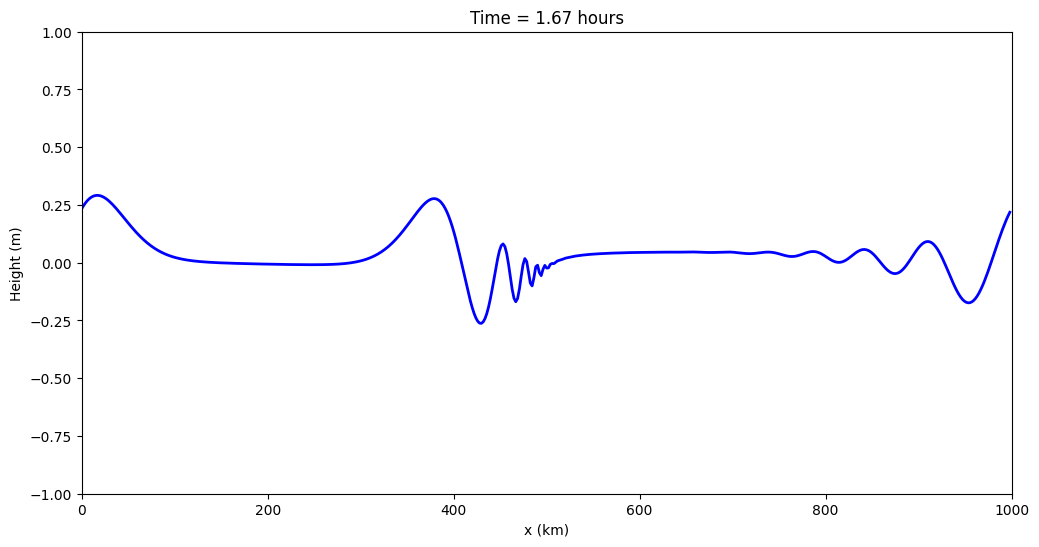

In [125]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

Given the following equations, one-dimensional in $x$:

$$ \frac{\partial u}{\partial t} + g \frac{\partial h}{\partial x} = - u \frac{\partial u}{\partial x}$$

$$ \frac{\partial h}{\partial t} + \frac{\partial (Hu)}{\partial x} = -\frac{\partial (hu)}{\partial x}$$


but $u$ and $h$ ($\eta$ in the lectures) are small, and so their products are negligible, and also the water column height, $H$ ($ = H_0 - h_b$ in lectures), varies slowly, so we can say H is not a function of $x$, so can be pulled outside the derivative for the second term of the second equation, such that:

$$\frac{\partial (Hu)}{\partial x} \approx H \frac{\partial u}{\partial x}$$

$$ u \frac{\partial u}{\partial x}, \frac{\partial (hu)}{\partial x} \approx 0 $$

so

(1) $ \frac{\partial u}{\partial t} = -g \frac{\partial h}{\partial x} $

(2) $ \frac{\partial h}{\partial t} + H \frac{\partial u}{\partial x} = 0$

Take $\frac{\partial}{\partial x}$ of (1) and $\frac{\partial}{\partial t}$ of (2):

(3) $ \frac{\partial u}{\partial t \partial x} = -g \frac{\partial^2 h}{\partial x^2} $

(4) $ \frac{\partial^2 h}{\partial t^2} + H \frac{\partial u}{\partial x \partial t} = 0$

Sub (3) into (4)

$ \frac{\partial^2 h}{\partial t^2} + -gH \frac{\partial^2 h}{\partial x^2} = 0$

Look for solutions of form:

$$ h = h_0 cos (kx - \omega t)$$

where $h_0$ is the amplitude of the waves, $k$ is the angular wavenumber ($ = \frac{2 \pi }{\lambda}$, where $\lambda$ is the wavelength), and $\omega$ is the angular frequency ($= \frac{2 \pi }{T}$, where T is the period).

By comparison with the general form of the 1D wave equation, $ \frac{\partial^2 h}{\partial t^2} = c^2 \frac{\partial^2 h}{\partial x^2}$, the wavespeed, $ c = \pm \sqrt{gH}$.

Note: given $c= \frac{\omega}{k}$, $\omega = \pm \sqrt{gH}k$. Therefore $ h = h_0 cos (k(x \pm \sqrt{gH} t))$.

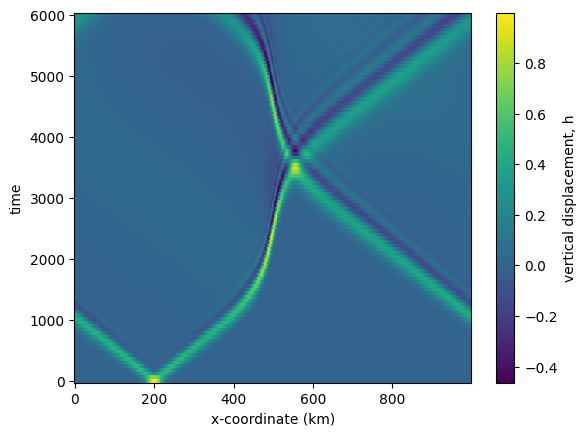

In [126]:
# Visualise the wave in terms of x and t
fig, ax = plt.subplots()
plt.pcolormesh(x/1000, t_save, h_save)
ax.set_xlabel("x-coordinate (km)")
ax.set_ylabel("time")
plt.colorbar(label="vertical displacement, h", ax=ax)

Text(0.5, 1.0, 'Height of water column (varying due to bathymetry)')

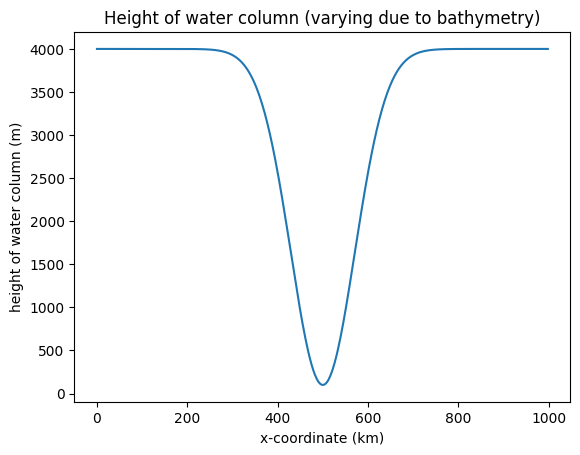

In [127]:
# Plot height of water column (which varies according to bottom bathymetry)
fig, ax = plt.subplots()
plt.plot(x/1000, H['g'])
ax.set_xlabel("x-coordinate (km)")
ax.set_ylabel("height of water column (m)")
ax.set_title("Height of water column (varying due to bathymetry)")

Text(0.5, 1.0, 'Wave speed, as predicted by water column height (c=$\\sqrt{gH}$)')

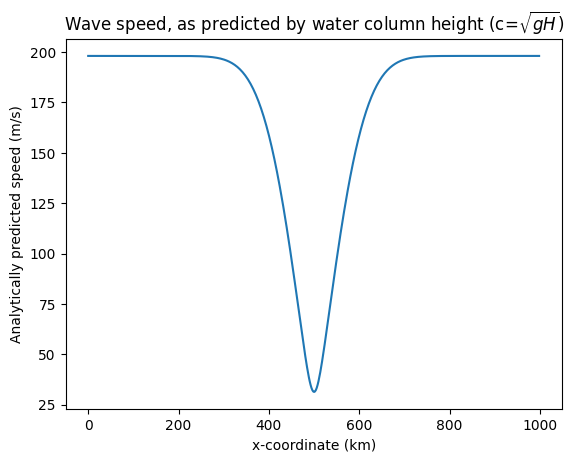

In [128]:
fig, ax = plt.subplots()
ax.plot(x/1000, np.sqrt(g*H['g']))
ax.set_xlabel("x-coordinate (km)")
ax.set_ylabel("Analytically predicted speed (m/s)")
ax.set_title("Wave speed, as predicted by water column height (c=$\sqrt{gH}$)")

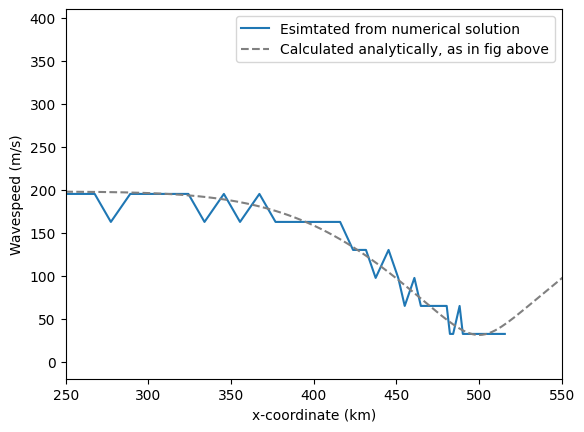

In [129]:
# Find the x-coordinates of the max waveheight (in h_save) for each of the first 50 timesteps
x_peak = x[np.argmax(h_save[:50,95:],axis=1)+95]
u_peak = np.zeros(50)

# For each timestep, estimate speed (using distance over time)
for i in range(1,50):
  u_peak[i] = (x_peak[i]-x_peak[i-1])/timestep

fig, ax = plt.subplots()

ax.plot(x_peak/1000,u_peak, label="Esimtated from numerical solution")
ax.set_xlim(250,550)
ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('Wavespeed (m/s)')
ax.plot(x/1000, np.sqrt(g*H['g']), label='Calculated analytically, as in fig above', c='gray', linestyle='--')
ax.legend()

The numerical solution follows the analytical prediction fairly closely, with obvious discretisation of the gradient due to the limitations of the timestep. On a wider x-domain, or on wider timesteps, this breaks down due to the difficulty of following a single peak using the np.argmax function (hence why only the first 50 timesteps have been chosen, and the spatial domain has been restricted).

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [130]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2024-12-27 15:39:56,044 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.4e+01/s


2024-12-27 15:39:56,109 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.4e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.4e+01/s


2024-12-27 15:39:56,200 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.4e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s


2024-12-27 15:39:56,299 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s


2024-12-27 15:39:56,419 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s


2024-12-27 15:39:56,512 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 4.3e+01/s


2024-12-27 15:39:56,581 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 4.3e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.5e+01/s


2024-12-27 15:39:56,638 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2024-12-27 15:39:56,711 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:__main__:Starting main loop


2024-12-27 15:39:56,722 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-27 15:39:57,270 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-27 15:39:57,276 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-27 15:39:57,282 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.7649 sec


2024-12-27 15:39:57,286 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7649 sec


INFO:solvers:Warmup time (iter 0-10): 0.2499 sec


2024-12-27 15:39:57,288 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2499 sec


INFO:solvers:Run time (iter 10-end): 0.2947 sec


2024-12-27 15:39:57,291 solvers 0/1 INFO :: Run time (iter 10-end): 0.2947 sec


INFO:solvers:CPU time (iter 10-end): 8.187e-05 cpu-hr


2024-12-27 15:39:57,293 solvers 0/1 INFO :: CPU time (iter 10-end): 8.187e-05 cpu-hr


INFO:solvers:Speed: 1.616e+06 mode-stages/cpu-sec


2024-12-27 15:39:57,295 solvers 0/1 INFO :: Speed: 1.616e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 15:39:57,391 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe4xhjw_g/temp.m4v


2024-12-27 15:39:57,396 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe4xhjw_g/temp.m4v


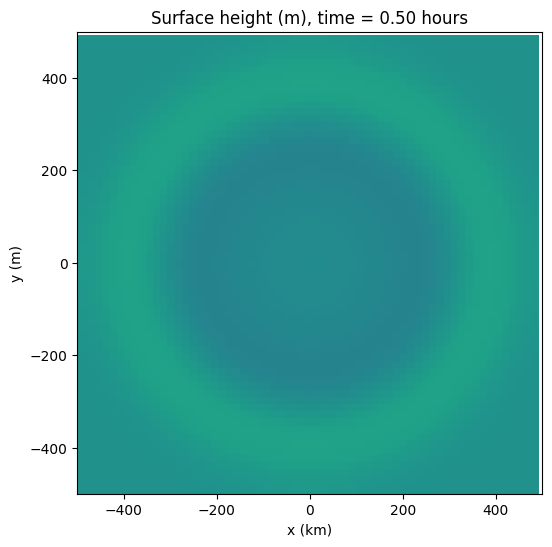

In [131]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)


from IPython.display import HTML
HTML(anim.to_html5_video())

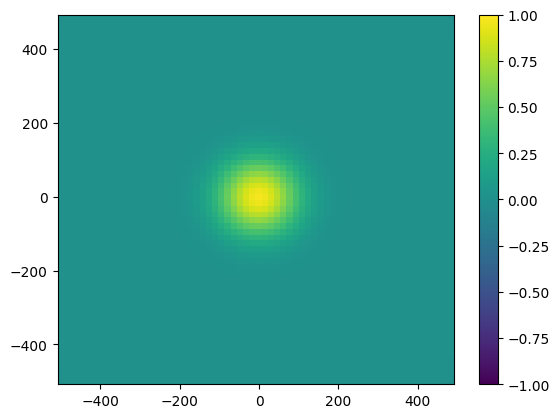

In [132]:
# One more plot, this time with a colorbar
fig, ax = plt.subplots()
height = ax.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[1,:,:], vmin=-1, vmax=1)
fig.colorbar(height, ax=ax)

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

$$ \text{kinetic energy per unit area, } E_k = \frac{1}{2}\rho(u^2 + v^2)(H+h)$$

$$ \text{potential energy per unit area, } E_p = \rho g \frac{(H+h)^2}{2}$$

$$\int\int(E_k+E_p) dx dy = constant$$

No seamount this time

$$\rho \int\int \left( \frac{1}{2}\left(\left(\frac{dx}{dt}\right)^2 + \left(\frac{dy}{dt}\right)^2\right)(H+h) + g \frac{(H+h)^2}{2} \right) dx dy = constant$$

The amplitude should follow an inverse square law, decaying from the initial disturbance value of 1 in accordance with the square of the distance. The distance from the origin is $\sqrt{x^2+y^2}$, so the amplitude of the wave should go as follows $h \sim \frac{1}{x^2+y^2}$.

(-10.0, 10.0)

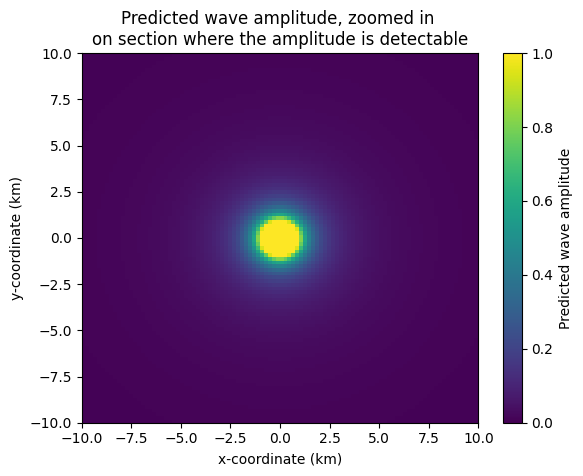

In [133]:
# Plot predicted wave amplitude using inverse square law
fig, ax = plt.subplots()
x_fine=np.linspace(-100*kilometer, 100*kilometer, 1000)
y_fine=np.linspace(-100*kilometer, 100*kilometer, 1000)
X, Y = np.meshgrid(x_fine/(1*kilometer), y_fine/(1*kilometer))
colours=ax.pcolor(X, Y, 1/(X**2+Y**2), vmin=0, vmax=1)
fig.colorbar(colours, label="Predicted wave amplitude")
ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('y-coordinate (km)')
ax.set_title('Predicted wave amplitude, zoomed in \non section where the amplitude is detectable')
ax.set_xlim(-10, 10)
ax.set_ylim(-10,10)

<ipython-input-134-8545ecfabe56>:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(x/1000, np.sqrt(1/(x**2+y**2)))


Text(0.5, 1.0, 'Predicted wave amplitude as a function of x, at y=0')

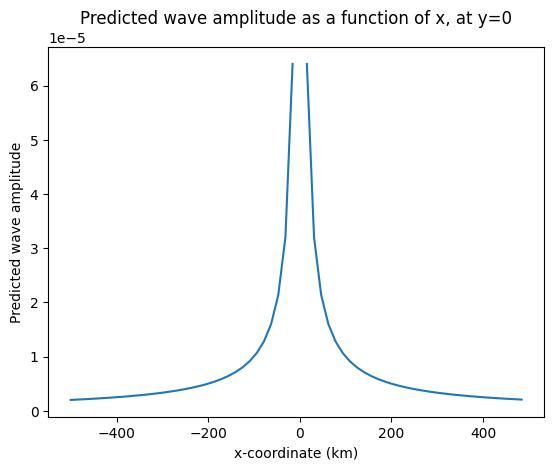

In [134]:
# Plot amplitude as a function of x only, with y=0
fig, ax = plt.subplots()
y=0
ax.plot(x/1000, np.sqrt(1/(x**2+y**2)))
ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('Predicted wave amplitude')
ax.set_title('Predicted wave amplitude as a function of x, at y=0')

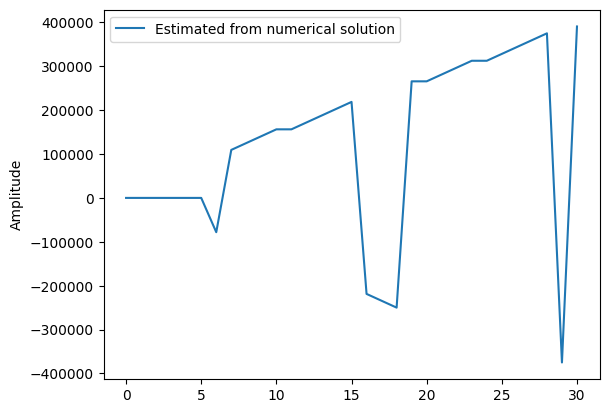

In [135]:
# Find the x-coordinates of the max waveheight (in h_save) for each of the first 50 timesteps, at y=0, on the left hand side of the graph
x_peak = x[np.argmax(h_save[:50,:,32],axis=1)]

fig, ax = plt.subplots()

ax.plot(x_peak, label="Estimated from numerical solution")
#ax.set_xlim(250,550)
#ax.set_xlabel('x-coordinate (km)')
ax.set_ylabel('Amplitude')
ax.legend()

In [136]:
# # Do the same for y (should be the same as radially symmetrical)

# indices = np.argmax(h_save[:10, 32, :32], axis=1)
# y_peak = y[0, indices]
# u_peak = np.zeros(10)

# # For each timestep, estimate speed (using distance over time)
# for i in range(1,10):
#   u_peak[i] = (y_peak[i]-y_peak[i-1])/timestep

# fig, ax = plt.subplots()

# ax.plot(y_peak/1000,np.abs(u_peak), label="Esimtated from numerical solution")
# #ax.set_xlim(250,550)
# ax.set_xlabel('y-coordinate (km)')
# ax.set_ylabel('Wavespeed (m/s)')
# ax.legend()

ADD DISCUSSION HERE (~1 paragraph)

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [137]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


2024-12-27 15:40:28,784 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.8e+01/s


2024-12-27 15:40:28,882 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.8e+01/s


2024-12-27 15:40:29,003 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.6e+01/s


2024-12-27 15:40:29,138 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.6e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s


2024-12-27 15:40:29,258 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


2024-12-27 15:40:29,376 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


2024-12-27 15:40:29,489 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


2024-12-27 15:40:29,609 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


2024-12-27 15:40:29,745 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


2024-12-27 15:40:29,874 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.7e+01/s


INFO:__main__:Starting main loop


2024-12-27 15:40:29,882 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-27 15:41:53,289 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-27 15:41:53,294 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-27 15:41:53,299 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 4.188 sec


2024-12-27 15:41:53,302 solvers 0/1 INFO :: Setup time (init - iter 0): 4.188 sec


INFO:solvers:Warmup time (iter 0-10): 2.126 sec


2024-12-27 15:41:53,306 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.126 sec


INFO:solvers:Run time (iter 10-end): 78.26 sec


2024-12-27 15:41:53,308 solvers 0/1 INFO :: Run time (iter 10-end): 78.26 sec


INFO:solvers:CPU time (iter 10-end): 0.02174 cpu-hr


2024-12-27 15:41:53,310 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02174 cpu-hr


INFO:solvers:Speed: 4.418e+05 mode-stages/cpu-sec


2024-12-27 15:41:53,312 solvers 0/1 INFO :: Speed: 4.418e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 15:41:53,476 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpv0i_gk5d/temp.m4v


2024-12-27 15:41:53,480 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpv0i_gk5d/temp.m4v


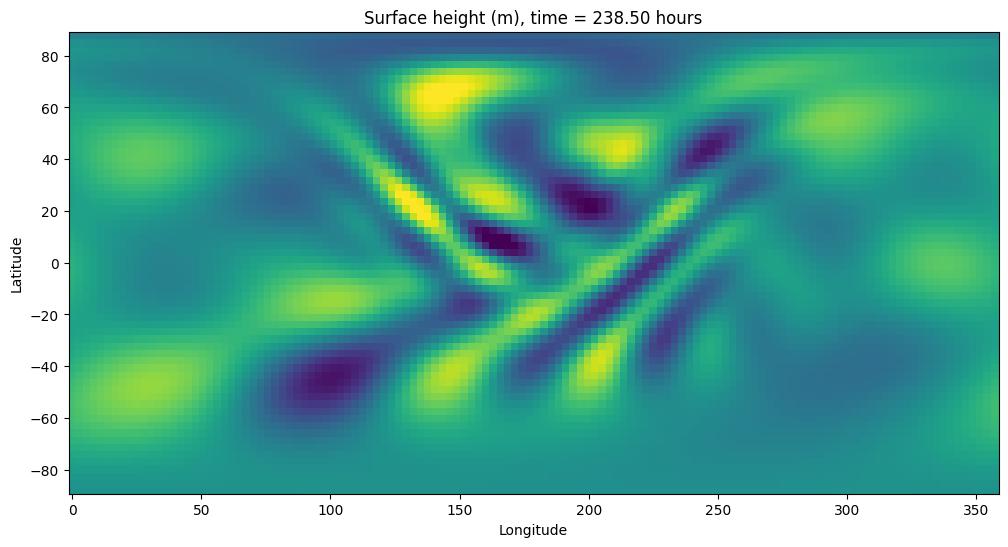

In [138]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

Text(0.5, 1.0, 'Virtual tide gauge')

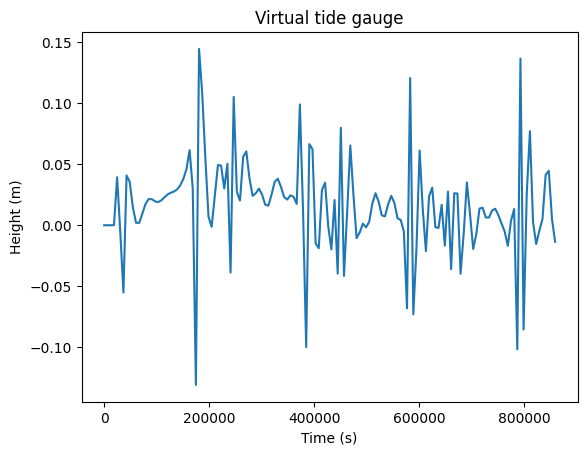

In [139]:
# Plot a virtual tide gauge at lat = 45 N (colat=45), and long = 90 W (azimuth = -90)
fig, ax = plt.subplots()
ax.plot(t_save, h_save[:,-90,45])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Height (m)')
ax.set_title('Virtual tide gauge')

The shape of the wave may change if the wave is dispersive, ie there will be a sorting of waves according to wavenumber. Further, there may be constructive and destructive interference as waves reach around the world and interact with waves that have done the same but in the opposite direction.


---



In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [140]:
# SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

tau = 0.1 * day # damping timescale of 0.1 days

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")

#Create a Dedalus field for the damping function

damping_func = dist.Field(name='damping_func', bases=basis)
damping_func['g'] = 0.5*(1+np.tanh((phi-1.5*np.pi)/(np.pi/10))) + 0.5 * (1-np.tanh((phi-0.5*np.pi)/(np.pi/10)))

# Incorporate into problem
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - (1/tau) * damping_func * h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


2024-12-27 15:42:38,059 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.3e+01/s


2024-12-27 15:42:38,234 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2024-12-27 15:42:38,411 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2024-12-27 15:42:38,591 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2024-12-27 15:42:38,760 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.9e+01/s


2024-12-27 15:42:38,931 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.9e+01/s


2024-12-27 15:42:39,103 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


2024-12-27 15:42:39,284 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


2024-12-27 15:42:39,457 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.9e+01/s


2024-12-27 15:42:39,625 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.9e+01/s


INFO:__main__:Starting main loop


2024-12-27 15:42:39,633 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-27 15:44:12,863 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-27 15:44:12,867 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-27 15:44:12,871 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.531 sec


2024-12-27 15:44:12,874 solvers 0/1 INFO :: Setup time (init - iter 0): 5.531 sec


INFO:solvers:Warmup time (iter 0-10): 1.668 sec


2024-12-27 15:44:12,876 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.668 sec


INFO:solvers:Run time (iter 10-end): 87.71 sec


2024-12-27 15:44:12,878 solvers 0/1 INFO :: Run time (iter 10-end): 87.71 sec


INFO:solvers:CPU time (iter 10-end): 0.02436 cpu-hr


2024-12-27 15:44:12,880 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02436 cpu-hr


INFO:solvers:Speed: 3.942e+05 mode-stages/cpu-sec


2024-12-27 15:44:12,883 solvers 0/1 INFO :: Speed: 3.942e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 15:44:13,043 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp88k1597z/temp.m4v


2024-12-27 15:44:13,048 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp88k1597z/temp.m4v


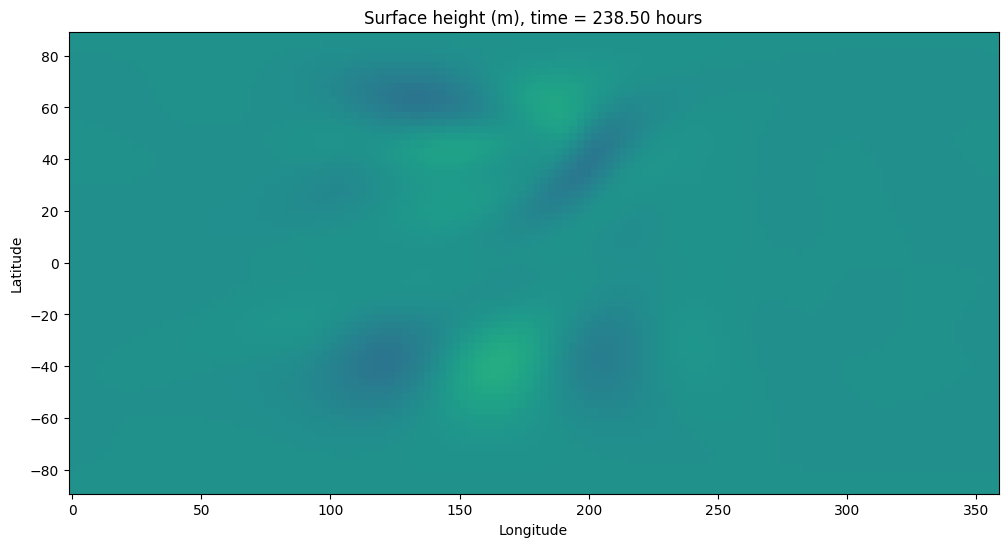

In [141]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [142]:
h_save.shape

(145, 128, 64)

Text(0.5, 1.0, 'Height as f(longitude) at $t\\approx 165 hours$')

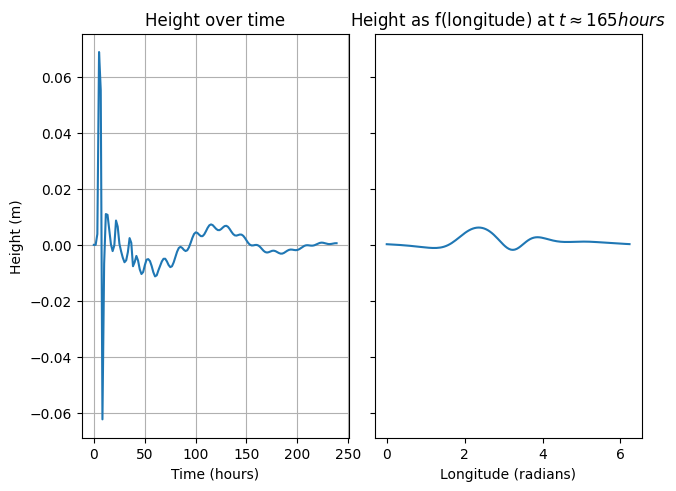

In [143]:
# Plot h as a function of longitude and time
fig, ax = plt.subplots(ncols=2, sharey=True, layout='constrained')
ax[0].plot((np.array(t_save)/3600.), h_save[:,64,32])
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Height (m)')
ax[0].grid()
ax[0].set_title('Height over time')
ax[1].plot(phi, h_save[100,:,32])
ax[1].set_xlabel('Longitude (radians)')
ax[1].set_title('Height as f(longitude) at $t\\approx 165 hours$')

From these graphs, the phase speed is given by $v=f\lambda$ for the small oscilations (the larger scale wave pattern with period ~100 hours is the group velocity).

The right hand plot suggests a wavelength approximately $ \lambda \approx 1.5 \space rad$, while the period of the small-scale oscillations on the graph on the left is
about 60 000 seconds, suggesting $f \approx 1.7 \times 10^{-5} \space \text{Hz}$. This implies a wavespeed of $2.5 \times 10^{-5} \space rad/s$ or $1.4 \times 10^{-3} \space °/s$.

This is about an order of magnitude faster than the northern east-to-west Rossby wave speed visible in the animation, where the crest (in yellow) travels approximately 30° in 100 hours, which gives a phase speed of roughly $8 \times 10^{-5}\space °/s$.

The Rossby wave pattern we see in the animation is at the mid-latitudes, either side of the equator, but more visible in the northern hemisphere. There appears to be a phase velocity and a group velocity, as the waves fade by the time they reach approximately 80° of longitude.

The fainter pattern in the southern hemisphere travels faster (approx $3 \times 10^{-4}\space °/s$).

This discrepancy could be because I have plotted the time vs longitude graph for the equator, when actually the Rossby waves are north and south of the equator. I try a mid latitude below.

Text(0.5, 1.0, 'Height as f(longitude) at $t\\approx 165 hours$')

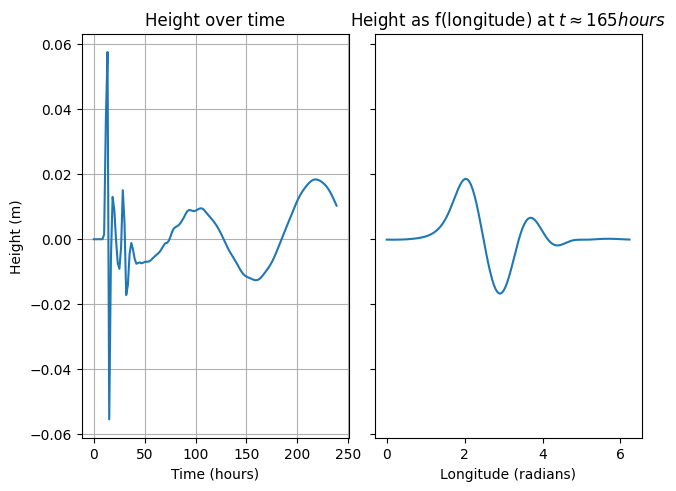

In [144]:
# Plot h as a function of longitude and time
fig, ax = plt.subplots(ncols=2, sharey=True, layout='constrained')
ax[0].plot((np.array(t_save)/3600.), h_save[:,64,16])
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Height (m)')
ax[0].grid()
ax[0].set_title('Height over time')
ax[1].plot(phi, h_save[100,:,16])
ax[1].set_xlabel('Longitude (radians)')
ax[1].set_title('Height as f(longitude) at $t\\approx 165 hours$')

This does not fully explain the discrepancy either. Another possible explanation is that it could be due to dispersion that is not visible on the colourscale used by the animation.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?